In [ ]:
# Balance classes
# outliers, scaling,
# EDA
#

In [9]:
# Mount to google drive where data is stored
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## PySpark Setup

In [1]:
# If you encounter any problems visit the apache.org link and ensure you have selected the right tgz file
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www.apache.org/dist/spark/spark-3.2.4/spark-3.2.4-bin-hadoop2.7.tgz
!tar xf spark-3.2.4-bin-hadoop2.7.tgz


In [2]:
#import shutil

#shutil.rmtree('/content/gdrive/MyDrive/CSP 572/spark-3.2.4-bin-hadoop2.7')

In [3]:
# Setting the appropriate paths for Spark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.4-bin-hadoop2.7"

!pip install -q findspark
import findspark
findspark.init()

## Import libraries

In [4]:
import matplotlib.pyplot as plt

In [5]:

from pyspark.sql.functions import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit, to_timestamp, log
from pyspark.sql import Window
import pyspark.sql.functions as f
from pyspark.sql import Window
from pyspark.sql import functions as F
from pyspark.sql.types import StringType, DateType, FloatType
import pandas as pd
from pyspark.sql.functions import mean as _mean, stddev as _stddev, col

In [6]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
#!pip install pyspark_dist_explore
#from pyspark_dist_explore import hist
#import matplotlib.pyplot as plt

In [7]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, ConfusionMatrixDisplay

In [10]:
# Change directory
import os
os.chdir("/content/gdrive/MyDrive/CSP 572/")

In [11]:

# Create a spark session
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()


## Read Data

In [12]:
# Read 2021 data
data = spark.read.csv("2021.rpt", header=None, sep="|")

In [13]:
# Read the header file
header = pd.read_csv("Header.rpt", sep="|")
cols = header.columns
data = data.toDF(*cols)


In [14]:
# Read all other data files
#data_2021 = spark.read.csv("2022.rpt", header=None, sep="|")
data_2020 = spark.read.csv("2020.rpt", header=None, sep="|")
data_2019 = spark.read.csv("2019.rpt", header=None, sep="|")
data_2018 = spark.read.csv("2018.rpt", header=None, sep="|")
data_2017 = spark.read.csv("2017.rpt", header=None, sep="|")

In [15]:
# Combine all data
#data = data.union(data_2022)
data = data.union(data_2020)
data = data.union(data_2019)
data = data.union(data_2018)
data = data.union(data_2017)

In [16]:
# Numeric columns list - add to this as you see fit
numeric_cols = ["AdjustedAmountDue1", "TaxAmountDue1", "InterestAmountDue1", "CostAmountDue1", "TotalAmountDue1", "OriginalTaxDue2",
        "AdjustedTaxDue2", "TaxAmountDue2", "InterestAmountDue2", "CostAmountDue2", "TotalAmountDue2", "AssessedValuation",
        "EqualizedEvaluation", "TaxRate", "LastPaymentReceivedAmount1", "LastPaymentReceivedAmount2"
        ] + list(data.columns)[70:81]

In [17]:
# Convert to numeric columns
for col_name in numeric_cols:
    data = data.withColumn(col_name, col(col_name).cast('float'))


# Remove 3 rows which have garbage values
data = data.where(data.SegmentCode=="PH")

### Target Variable
Our target variable is Late Payment in 2nd Installment Y/N. We get this from the InstDates.csv (available in 'Helper datasets' folder in the shared drive) which contains the payment due dates of each year for each installment.

In [18]:
instDates = spark.read.csv("InstDates.csv", header=True)
instDates = instDates.withColumn("Year", col("Year").cast("int"))
instDates = instDates.where(instDates.Year>=2017)
instDates = instDates.withColumnRenamed("Inst1", "PmtDue1")
instDates = instDates.withColumnRenamed("Inst2", "PmtDue2")

In [19]:
data = data.join(instDates, data.TaxYear==instDates.Year, "left")
data = data.withColumn("LastPaymentDate1", to_date(col("LastPaymentDate1"), "MMddyyyy"))
data = data.withColumn("LastPaymentDate2", to_date(col("LastPaymentDate2"), "MMddyyyy"))
data = data.withColumn("PmtDue1", to_date(col("PmtDue1"), "yyyy-MM-dd"))
data = data.withColumn("PmtDue2", to_date(col("PmtDue2"), "yyyy-MM-dd"))
data = data.withColumn("LatePmt1", when(col("LastPaymentDate1")>col("PmtDue1"), 1).otherwise(0))
data = data.withColumn("LatePmt2", when(col("LastPaymentDate2")>col("PmtDue2"), 1).otherwise(0))


In [ ]:
# Persist data in disk/memory
# Until this point Spark does not actually execute any of the above statements (Lazy loading). It only creates a plan
# Persist does not get executed until an 'action' command is called on the dataframe
#data1 = data.persist()

In [ ]:
# The below action with persist called above will ensure that all the steps until data.persist() is run and stored in memory/disk
# Only the first run takes approx 10 mins. If you run it again, it will only take 3 secs as the data is now stored in memory/disk
# It helps in using the modified dataframe directly
# If you do not persist, Spark is going to run all the steps right from read_csv whenever you call an action
#print([data1.count(), len(data1.columns)])

In [ ]:
#data1.where(col("LatePmt2")==1).count()

In [20]:
data1 = data

### Payment Master data
Please do not run this section as it is not used yet. Proceed to 'Drop columns' part if you want to run the whole model.

In [ ]:

pmt_2021 = spark.read.csv("TY2021.rpt", sep=",", header=True)

In [ ]:
print([pmt_2021.count(), len(pmt_2021.columns)])

[3339581, 17]


In [ ]:
pmt_2021.columns

In [ ]:
pmt_2021.where(col("PIN")=="09143170550000").show()

+-------+------+--------------+-------+--------------------+-------+----------+-------+------------+--------+----------------+----------+-------------------+------------+---------+--------+-----------+
|Payment|Volume|           PIN|TaxType|            TaxPayer|TaxYear|  DatePaid|TaxPaid|InterestPaid|CostPaid|    SerialNumber|  SourceID|        DateUpdated|RefundNumber|TotalPaid|TaxYear4|WarrantYear|
+-------+------+--------------+-------+--------------------+-------+----------+-------+------------+--------+----------------+----------+-------------------+------------+---------+--------+-----------+
|     P1|   088|09143170550000|      0|DIANE S FAGIANO  ...|   21  |230209    |2422.03|      435.96|    0.00|021023500337    |750       |2023-02-11 05:31:00|        NULL|  2857.99|    2021|       2021|
|     P2|   088|09143170550000|      0|DIANE S FAGIANO  ...|   21  |230209    |2234.76|       67.04|    0.00|021023500337    |750       |2023-02-11 05:31:00|        NULL|  2301.80|    2021|   

## Analysis
Just some EDA on the dataset. TProceed to 'Drop columns' part if you want to run the whole model.

In [ ]:
data1 = data1.withColumn("TaxSale", when(data1.LastPaymentDate2=="00000000", 1).otherwise(0))

In [27]:
tot = data1.count()

In [ ]:
# Univariate analysis
var = "LastPaymentSource1"
data1.groupBy(var).agg(count(var), count(var)/tot*100).show()

+----------------------+-----------------------------+-------------------------------------------------+
|TaxpayerPropertySuffix|count(TaxpayerPropertySuffix)|((count(TaxpayerPropertySuffix) / 9325500) * 100)|
+----------------------+-----------------------------+-------------------------------------------------+
|                     1|                      1452585|                               15.576483834646936|
|                     2|                      6899714|                                73.98760388182939|
|                     0|                       973201|                                10.43591228352367|
+----------------------+-----------------------------+-------------------------------------------------+



In [ ]:
data1.where(data1.PastTaxSaleStatus=="Y").show()

+-----------+--------------+------+--------------+--------------------+----------------------+--------------------+--------------------+------------------+---------------------+-------------------------+----------------------+----------------------+--------------------+---------------------+-------------------+--------------------+-------+---------+---------------+------------+------------------+------------------------+-----------+-------+-------+--------+-------------+--------+------------+------------------+------------------+-------------+----------------------------+------------------+---------------------------+--------------+-----------------------+---------------+------------------------+----------------+------------------+------------------+---------------+---------------+-------------+----------------------------+------------------+---------------------------+--------------+-----------------------+---------------+----------------------+----------------+------------------+----

In [ ]:
data1.where(data1.PastTaxSaleStatus=="Y").count()

272729

In [ ]:
data1.where((data1.PastTaxSaleStatus=="Y") & (data1.TaxSale==1)).count()

195448

In [ ]:
data1.where((data1.PastTaxSaleStatus=="Y") & (data1.TaxSale==0)).show()

+-----------+--------------+------+--------------+--------------------+----------------------+--------------------+--------------------+------------------+---------------------+-------------------------+----------------------+----------------------+--------------------+---------------------+-------------------+--------------------+-------+---------+---------------+------------+------------------+------------------------+-----------+-------+-------+--------+-------------+--------+------------+------------------+------------------+-------------+----------------------------+------------------+---------------------------+--------------+-----------------------+---------------+------------------------+----------------+------------------+------------------+---------------+---------------+-------------+----------------------------+------------------+---------------------------+--------------+-----------------------+---------------+----------------------+----------------+------------------+----

In [ ]:
data1.where(data.PIN=="09143170550000").show()

+-----------+--------------+------+--------------+--------------------+----------------------+--------------------+--------------------+------------------+---------------------+-------------------------+----------------------+----------------------+--------------------+---------------------+-------------------+--------------------+-------+---------+---------------+------------+------------------+------------------------+-----------+-------+-------+--------+-------------+--------+------------+------------------+------------------+-------------+----------------------------+------------------+---------------------------+--------------+-----------------------+---------------+------------------------+----------------+------------------+------------------+---------------+---------------+-------------+----------------------------+------------------+---------------------------+--------------+-----------------------+---------------+----------------------+----------------+------------------+----

In [ ]:
analysis_cols = ["PIN", "TaxYear", "LastPaymentDate1", "LastPaymentDate2", "AdjustedAmountDue1", "PastTaxSaleStatus", "PastTaxSaleStatusSum"]
#"TotalAmountDue1", "TotalAmountDue2",
data2.where(data2.PIN=="09143170550000").select(*analysis_cols).show()

+--------------+-------+----------------+----------------+------------------+-----------------+--------------------+
|           PIN|TaxYear|LastPaymentDate1|LastPaymentDate2|AdjustedAmountDue1|PastTaxSaleStatus|PastTaxSaleStatusSum|
+--------------+-------+----------------+----------------+------------------+-----------------+--------------------+
|09143170550000|   2017|      2018-02-14|      2018-07-16|          123845.0|                0|                   0|
|09143170550000|   2018|      2019-02-19|      2019-07-23|           96165.0|                0|                   0|
|09143170550000|   2019|      2020-02-20|      2020-07-23|           98857.0|                0|                   0|
|09143170550000|   2020|      2021-02-26|      2022-11-15|          187403.0|                0|                   0|
|09143170550000|   2021|      2023-02-09|      2023-02-09|          242203.0|                1|                   1|
+--------------+-------+----------------+----------------+------

In [ ]:
data2.where(data2.PIN=="08322000171119").select(*analysis_cols).show()

+--------------+-------+----------------+----------------+------------------+-----------------+--------------------+
|           PIN|TaxYear|LastPaymentDate1|LastPaymentDate2|AdjustedAmountDue1|PastTaxSaleStatus|PastTaxSaleStatusSum|
+--------------+-------+----------------+----------------+------------------+-----------------+--------------------+
|08322000171119|   2017|      2019-05-03|      2019-05-03|           45910.0|                0|                   0|
|08322000171119|   2018|      2019-08-13|      2019-08-27|           35990.0|                1|                   1|
|08322000171119|   2019|      2020-03-30|      2020-10-19|           87176.0|                1|                   2|
|08322000171119|   2020|      2021-05-18|      2022-11-15|          127151.0|                0|                   2|
|08322000171119|   2021|      2023-02-22|      2023-02-22|          124765.0|                1|                   3|
+--------------+-------+----------------+----------------+------

In [ ]:

temp_df = data2.where(data2.PIN=="08322000171119").persist()


+--------------+------+--------------+--------------------+----------------------+--------------------+--------------------+-------+---------+---------------+------------+------------------+-------+-------------+--------+------------------+-------------+--------------+----------------+------------------+----------------+----------+-----------------+-------+------------------+--------------------------+-----------------+------------+--------------+------------+---------------------------+-----------------------------+--------------------------+--------------------------------+---------------------+------------------------+------------------------------+----+----------+----------+--------+--------+--------------------+-----------+
|           PIN|Volume|Classification|TaxpayerMailingState|TaxpayerPropertySuffix|TaxpayerPropertyCity|TaxpayerPropertyTown|TaxCode|TaxStatus|HomeownerExempt|SeniorExempt|SeniorFreezeExempt|TaxYear|AccountStatus|BillType|AdjustedAmountDue1|TaxAmountDue1|CostAmo

+--------------+------+--------------+--------------------+----------------------+--------------------+--------------------+-------+---------+---------------+------------+------------------+-------+-------------+--------+------------------+-------------+--------------+----------------+------------------+----------------+----------+-----------------+-------+------------------+--------------------------+-----------------+------------+--------------+------------+---------------------------+-----------------------------+--------------------------+--------------------------------+---------------------+------------------------+------------------------------+----+----------+----------+--------+--------+--------------------+-----------+
|           PIN|Volume|Classification|TaxpayerMailingState|TaxpayerPropertySuffix|TaxpayerPropertyCity|TaxpayerPropertyTown|TaxCode|TaxStatus|HomeownerExempt|SeniorExempt|SeniorFreezeExempt|TaxYear|AccountStatus|BillType|AdjustedAmountDue1|TaxAmountDue1|CostAmo

In [ ]:
temp_df.dtypes

[('PIN', 'string'),
 ('Volume', 'int'),
 ('Classification', 'string'),
 ('TaxpayerMailingState', 'int'),
 ('TaxpayerPropertySuffix', 'string'),
 ('TaxpayerPropertyCity', 'int'),
 ('TaxpayerPropertyTown', 'string'),
 ('TaxCode', 'string'),
 ('TaxStatus', 'int'),
 ('HomeownerExempt', 'string'),
 ('SeniorExempt', 'string'),
 ('SeniorFreezeExempt', 'string'),
 ('TaxYear', 'string'),
 ('AccountStatus', 'string'),
 ('BillType', 'int'),
 ('AdjustedAmountDue1', 'float'),
 ('TaxAmountDue1', 'float'),
 ('CostAmountDue1', 'float'),
 ('LastPaymentDate1', 'date'),
 ('LastPaymentSource1', 'string'),
 ('LastPaymentDate2', 'date'),
 ('CofENumber', 'int'),
 ('PastTaxSaleStatus', 'int'),
 ('TaxRate', 'float'),
 ('CondemnationStatus', 'string'),
 ('MunicipalAcquisitionStatus', 'string'),
 ('AcquisitionStatus', 'string'),
 ('ExemptStatus', 'string'),
 ('BankruptStatus', 'string'),
 ('RefundStatus', 'string'),
 ('ReturningVetExemptionAmount', 'float'),
 ('DisabledPersonExemptionAmount', 'float'),
 ('Disabl

In [ ]:

data2.where(data2.PIN=="08322000171119").show()

+--------------+------+--------------+--------------------+----------------------+--------------------+--------------------+-------+---------+---------------+------------+------------------+-------+-------------+--------+------------------+-------------+--------------+----------------+------------------+----------------+----------+-----------------+-------+------------------+--------------------------+-----------------+------------+--------------+------------+---------------------------+-----------------------------+--------------------------+--------------------------------+---------------------+------------------------+------------------------------+----+----------+----------+--------+--------+--------------------+
|           PIN|Volume|Classification|TaxpayerMailingState|TaxpayerPropertySuffix|TaxpayerPropertyCity|TaxpayerPropertyTown|TaxCode|TaxStatus|HomeownerExempt|SeniorExempt|SeniorFreezeExempt|TaxYear|AccountStatus|BillType|AdjustedAmountDue1|TaxAmountDue1|CostAmountDue1|Last

In [ ]:
data1.where(data.PIN=="04201070150000").select(*analysis_cols).show()

+--------------+-------+----------------+----------------+------------------+---------------+--------------------------+--------------------------+-----------------+
|           PIN|TaxYear|LastPaymentDate1|LastPaymentDate2|AdjustedAmountDue1|AdjustedTaxDue2|LastPaymentReceivedAmount1|LastPaymentReceivedAmount2|PastTaxSaleStatus|
+--------------+-------+----------------+----------------+------------------+---------------+--------------------------+--------------------------+-----------------+
|04201070150000|   2022|        03032023|        00000000|          654054.0|            0.0|                  654054.0|                       0.0|                N|
|04201070150000|   2021|        02012022|        12052022|          626570.0|       562619.0|                  626570.0|                  562619.0|                N|
|04201070150000|   2020|        02022021|        08262021|          608158.0|       531061.0|                  608158.0|                  531061.0|                N|
|042

In [ ]:
data1.where(data.PIN=="09204140310000").select(*analysis_cols).show()

+--------------+-------+----------------+----------------+------------------+---------------+--------------------------+--------------------------+-----------------+
|           PIN|TaxYear|LastPaymentDate1|LastPaymentDate2|AdjustedAmountDue1|AdjustedTaxDue2|LastPaymentReceivedAmount1|LastPaymentReceivedAmount2|PastTaxSaleStatus|
+--------------+-------+----------------+----------------+------------------+---------------+--------------------------+--------------------------+-----------------+
|09204140310000|   2022|        04272023|        00000000|           31648.0|            0.0|                   31648.0|                       0.0|                Y|
|09204140310000|   2021|        03012023|        03012023|           31113.0|        26429.0|                   31113.0|                   26429.0|                Y|
|09204140310000|   2020|        11152022|        11152022|           27710.0|        28859.0|                   27710.0|                   28859.0|                N|
|092

In [ ]:
data1.where((data1.AdjustedAmountDue1!=0)&(data1.TotalAmountDue1==0)).count()

9876762

In [ ]:
data1.where((data1.TaxRate<30)&(data1.TaxRate>0)&(data1.AdjustedTaxDue2>0)).show()

In [ ]:
data1.where((data1.TaxRate<30)&(data1.TaxRate>0)&(data1.AdjustedTaxDue2>0)).show()

+-----------+--------------+------+--------------+--------------------+----------------------+--------------------+--------------------+------------------+---------------------+-------------------------+----------------------+----------------------+--------------------+---------------------+-------------------+--------------------+-------+---------+---------------+------------+------------------+------------------------+-----------+-------+-------+--------+-------------+--------+------------+------------------+------------------+-------------+----------------------------+------------------+---------------------------+--------------+-----------------------+---------------+------------------------+----------------+------------------+------------------+---------------+---------------+-------------+----------------------------+------------------+---------------------------+--------------+-----------------------+---------------+----------------------+----------------+------------------+----

In [ ]:

data1.where(data1.AdjustedAmountDue1 != data1.LastPaymentReceivedAmount1).show()

+-----------+--------------+------+--------------+--------------------+----------------------+--------------------+--------------------+------------------+---------------------+-------------------------+----------------------+----------------------+--------------------+---------------------+-------------------+--------------------+-------+---------+---------------+------------+------------------+------------------------+-----------+-------+-------+--------+-------------+--------+------------+------------------+------------------+-------------+----------------------------+------------------+---------------------------+--------------+-----------------------+---------------+------------------------+----------------+------------------+------------------+---------------+---------------+-------------+----------------------------+------------------+---------------------------+--------------+-----------------------+---------------+----------------------+----------------+------------------+----

In [31]:
# Univariate analysis
var = "LastPaymentSource1"
data1.groupBy(var).agg(count(var).alias("cnt"), count(var)/tot*100).sort(col("cnt").desc()).show(10)

+------------------+-------+---------------------------------------------+
|LastPaymentSource1|    cnt|((count(LastPaymentSource1) / 9325500) * 100)|
+------------------+-------+---------------------------------------------+
|               600|3705416|                            39.73423408932497|
|               700|1739914|                            18.65759476703662|
|               444|1412040|                           15.141708219398422|
|               000| 984367|                            10.55564849069755|
|               431| 486952|                           5.2217253766554075|
|               481| 320967|                           3.4418208138973783|
|               750| 195508|                           2.0964881239611817|
|               802| 144734|                           1.5520240201597768|
|               501| 102427|                           1.0983539756581415|
|               801|  62324|                           0.6683180526513324|
+------------------+-----

## Data Cleaning and Transformation

### Correlation analysis
Remove numerically correlated features with Pearson's correlation > 0.5 (the threshold can be discussed). Proceed to 'Drop columns' part if you want to run the whole model.

In [ ]:
c = data4.columns[-6:]
#data4 = data4.cast
for c1 in c:
  data4 = data4.withColumn(c1, data4[c1].cast("float"))

In [ ]:
data4.dtypes

In [ ]:
numeric_cols = []
for f in data4.schema.fields:
  if not isinstance(f.dataType, StringType):
    if not isinstance(f.dataType, DateType):
      numeric_cols.append(f.name)
numeric_cols

['Volume',
 'TaxpayerMailingState',
 'TaxpayerPropertyCity',
 'BillType',
 'AdjustedAmountDue1',
 'TaxAmountDue1',
 'CostAmountDue1',
 'CofENumber',
 'TaxRate',
 'ReturningVetExemptionAmount',
 'DisabledPersonExemptionAmount',
 'DisabledVetExemptionAmount',
 'DisabledPersonVetExemptionAmount',
 'HomeownerExemptAmount',
 'SeniorFreezeExemptAmount',
 'LongtimeHomeownersExemptAmount',
 'LatePmt1',
 'LatePmt2',
 'DiffPmt1',
 'WOE_TaxpayerPropertySuffix',
 'WOE_Classification',
 'WOE_TaxpayerPropertyTown',
 'WOE_TaxStatus',
 'WOE_AccountStatus',
 'WOE_LastPaymentSource1']

In [ ]:
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=numeric_cols, outputCol=vector_col)
df_vector = assembler.transform(data4).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)

In [ ]:
corr_matrix = matrix.collect()[0][0].toArray().tolist()
corr_matrix_df = pd.DataFrame(data=corr_matrix, columns = numeric_cols, index=numeric_cols)

In [ ]:
numeric_corr_cols = ["OriginalTaxDue2", "AdjustedTaxDue2", "AssessedValuation", "EqualizedEvaluation", "LastPaymentReceivedAmount2",
 "TaxDueEstimated1", "LastPaymentReceivedAmount1", "AdjustedAmountDue1_Org",
 "InterestAmountDue1", "TotalAmountDue1", "InterestAmountDue2", "TotalAmountDue2",
 "SeniorExemptAmount", "VeteranExempt"
 ]

In [ ]:
corr_matrix_df = corr_matrix_df.drop(numeric_corr_cols, axis=1)
corr_matrix_df = corr_matrix_df.drop(numeric_corr_cols, axis=0)

In [ ]:
corr_matrix_df.style.background_gradient(cmap='coolwarm').set_precision(2)

<ipython-input-80-68a7647adc47>:1: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr_matrix_df.style.background_gradient(cmap='coolwarm').set_precision(2)


,AdjustedAmountDue1,TaxAmountDue1,CostAmountDue1,TaxAmountDue2,CostAmountDue2,TaxRate,ReturningVetExemptionAmount,DisabledPersonExemptionAmount,DisabledVetExemptionAmount,DisabledPersonVetExemptionAmount,HomeownerExemptAmount,SeniorFreezeExemptAmount,LongtimeHomeownersExemptAmount,Year,LatePmt1,LatePmt2
AdjustedAmountDue1,1.00,0.05,-0.01,0.03,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.01,-0.01,-0.00,0.01,nan,-0.00
TaxAmountDue1,0.05,1.00,0.11,0.48,0.01,0.04,-0.00,-0.00,-0.00,-0.00,-0.01,-0.00,-0.00,0.00,nan,-0.01
CostAmountDue1,-0.01,0.11,1.00,0.06,-0.00,0.14,-0.00,-0.01,-0.01,-0.00,-0.07,-0.02,-0.00,-0.05,nan,-0.04
TaxAmountDue2,0.03,0.48,0.06,1.00,0.02,0.02,-0.00,-0.00,-0.00,-0.00,-0.01,-0.00,-0.00,0.00,nan,-0.00
CostAmountDue2,-0.00,0.01,-0.00,0.02,1.00,0.02,-0.00,-0.00,-0.00,-0.00,-0.02,-0.01,-0.00,-0.01,nan,-0.01
TaxRate,0.00,0.04,0.14,0.02,0.02,1.00,0.00,0.09,0.03,-0.00,0.08,-0.01,-0.01,-0.01,nan,0.04
ReturningVetExemptionAmount,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,1.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,nan,-0.00
DisabledPersonExemptionAmount,-0.00,-0.00,-0.01,-0.00,-0.00,0.09,-0.00,1.00,-0.00,-0.00,0.04,0.03,0.01,0.01,nan,-0.00
DisabledVetExemptionAmount,-0.00,-0.00,-0.01,-0.00,-0.00,0.03,-0.00,-0.00,1.00,-0.00,0.02,-0.00,-0.00,0.01,nan,-0.02
DisabledPersonVetExemptionAmount,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,1.00,0.00,-0.00,-0.00,0.00,nan,-0.00


### Outlier treatment
Outlier treatment of numerical variables capped by 1st and 99th percentile values, ie,
- if value < 1st percentile value, then use 1st percentile value
- if value > 99th percentile value, then use 99th percentile value

Proceed to 'Drop columns' part if you want to run the whole model.

In [ ]:
data1 = data1.withColumn("AdjustedAmountDue1", when(col("AdjustedAmountDue1")>3186751,3186751).otherwise(col("AdjustedAmountDue1")))

### Drop columns

- drop_cols_inst2 - Drop metrics related to installment2. This is needed for model 1 where we predict Late Payment for 2nd installment at Feb/Mar where we dont have this information yet
- drop_cols_univariate (Univariate analysis) - Group by categorical variables and get the count & %count of each category. If one of the categories in the feature is >95%, then remove this feature as it will not be very useful in the model. Some exceptions are present where the feature makes good business sense to be included
- drop_cols_numric_corr - Drop numerical columns that are correlated with Pearsons correlation >0.5


In [21]:
drop_cols_inst2 = data1.columns[42:53] + ["LastPaymentSource2"]
drop_cols_unrelated = ["SegmentCode", "TaxpayerName", "TaxpayerMailingAddress", "TaxpayerMailingZip",
                       "TaxpayerPropertyHouse","TaxpayerPropertyDirection", "TaxpayerPropertyStreet",
                       "TaxpayerPropertyZip", "RecordCount"
                       ]
drop_cols_univariate = ["LongtimeHomeownersExempt", "TaxInfoType", "TaxType", "TaxpayerPropertyState", "BillYear", "SegmentCode2",
                        "InstallmentNumber1", "RefundTaxAmountDueIndicator1", "RefundInterestDueIndicator1",
                        "RefundTotalDueIndicator1", "RefundCostDueIndicator1", "EndMarker", "TaxpayerMailingCity"
                        ]
drop_cols_numeric_corr = ["OriginalTaxDue2", "AdjustedTaxDue2", "AssessedValuation", "EqualizedEvaluation",
                          "LastPaymentReceivedAmount2", "TaxDueEstimated1", "LastPaymentReceivedAmount1",
                          "AdjustedAmountDue1_Org", "InterestAmountDue1", "TotalAmountDue1", "InterestAmountDue2",
                          "TotalAmountDue2", "SeniorExemptAmount", "VeteranExempt"]
#drop_cols_unverfied = ["Volume", "Classification", "TaxpayerPropertyTown", "LastPaymentDate1", "LastPaymentSource1"] # just dropping temporarily

In [22]:
data1 = data1.drop(*drop_cols_inst2)
data1 = data1.drop(*drop_cols_unrelated)
data1 = data1.drop(*drop_cols_univariate)
data1 = data1.drop(*drop_cols_numeric_corr)
#data1 = data1.drop(*drop_cols_unverfied)

### Data Transformation

In [23]:
data1 = data1.withColumn("TaxpayerPropertyCity", when(data1.TaxpayerPropertyCity=="CHICAGO", 1).otherwise(0))
data1 = data1.withColumn("TaxpayerMailingState", when(data1.TaxpayerMailingState=="IL", 1).otherwise(0))
data1 = data1.withColumn("BillType", when(data1.BillType=="1", 1).otherwise(0))
data1 = data1.withColumn("TaxSale", when(data1.LastPaymentDate2=="00000000", 1).otherwise(0))
data1 = data1.withColumn("CofENumber", when(data1.CofENumber=="0000000", 0).otherwise(1))
data1 = data1.withColumn("DiffPmt1", f.datediff(col("LastPaymentDate1"), col("PmtDue1")))
data1 = data1.withColumn("DiffPmt1", when(col("DiffPmt1")<0,0).otherwise(col("DiffPmt1")))
data1 = data1.withColumn("Volume", col("Volume").cast("int"))
data1 = data1.withColumn("TaxStatus", col("TaxStatus").cast("int"))
data1 = data1.withColumn("PastTaxSaleStatus", when(col("PastTaxSaleStatus")=="Y", 1).otherwise(0))

In [25]:
# Persist data in disk/memory
# Until this point Spark does not actually execute any of the above statements (Lazy loading). It only creates a plan
# Persist does not get executed until an 'action' command is called on the dataframe (action is count() here)
data2 = data1.persist()
print([data2.count(), len(data2.columns)])

[9325500, 44]


### WOE Transformation

In [ ]:
# Reference: https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html
def WOE_transform(df, var, y="LatePmt2"):
  woe_df = df.groupBy(var) \
    .agg(count(var).alias("cnt"), \
        sum(y).alias("cnt_1")) \
    .withColumn("cnt_0", col("cnt") - col("cnt_1")) \
    .withColumn("perc_1", col("cnt_1")/col("cnt")) \
    .withColumn("perc_0", col("cnt_0")/col("cnt")) \
    .withColumn("WOE_"+var, log(col("perc_0")/col("perc_1")))
  woe_df = woe_df.withColumn("WOE_"+var, f.round(col("WOE_"+var), 2))
  df = df.join(woe_df.select(*[var, "WOE_"+var]), [var])#.drop(woe_df[var])
  return(df)

In [ ]:
woe_transform_cols = ["TaxpayerPropertySuffix", "Classification", "TaxpayerPropertyTown",
                       "TaxStatus", "AccountStatus", "LastPaymentSource1"
                      #"Volume", "TaxCode"
                      ]

In [ ]:
for var in woe_transform_cols:
  data2 = WOE_transform(data2, var)
data2 = data2.drop(*woe_transform_cols)

In [ ]:
data3 = data2.persist()
print([data3.count(), len(data3.columns)])

[9325500, 44]


### Window Transformations

In [ ]:
windowval1 = (Window.partitionBy('PIN').orderBy('TaxYear')
             .rangeBetween(Window.unboundedPreceding, 0))
data3 = data3.withColumn('PastTaxSaleStatusSum', F.sum('PastTaxSaleStatus').over(windowval1))
windowval2 = (Window.partitionBy('PIN').orderBy('TaxYear')
            .rowsBetween(Window.unboundedPreceding, Window.currentRow-1))
data3 = data3.withColumn('LatePmt2Sum', F.sum('LatePmt2').over(windowval2))
data3 = data3.na.fill(value=0,subset=["LatePmt2Sum"])

windowval3 = (Window.partitionBy('PIN').orderBy('TaxYear')
            .rowsBetween(Window.unboundedPreceding, 0))
data3 = data3.withColumn('LatePmt1Sum', F.sum('LatePmt1').over(windowval3))

In [ ]:
data4 = data3.persist()
print([data4.count(), len(data4.columns)])

[9325500, 47]


In [ ]:
data4.show(5)

+------+--------------------+--------------------+-------+---------------+------------+------------------+--------+------------------+-------------+--------------+----------+-----------------+-------+------------------+--------------------------+-----------------+------------+--------------+------------+---------------------------+-----------------------------+--------------------------+--------------------------------+---------------------+------------------------+------------------------------+--------+--------+--------+--------------------------+------------------+------------------------+-------------+-----------------+----------------------+--------------------+-----------+-----------+
|Volume|TaxpayerMailingState|TaxpayerPropertyCity|TaxCode|HomeownerExempt|SeniorExempt|SeniorFreezeExempt|BillType|AdjustedAmountDue1|TaxAmountDue1|CostAmountDue1|CofENumber|PastTaxSaleStatus|TaxRate|CondemnationStatus|MunicipalAcquisitionStatus|AcquisitionStatus|ExemptStatus|BankruptStatus|RefundSt

### Drop other columns

In [ ]:
other_cols = ["LastPaymentDate1", "LastPaymentDate2", "TaxYear", "PmtDue1", "PmtDue2", "PIN",
              "TaxSale", "Year"]

In [ ]:
data4 = data4.drop(*woe_transform_cols)
data4 = data4.drop(*other_cols)

In [ ]:
string_cols = []
for c in data4.schema.fields:
  if isinstance(c.dataType, StringType):
    string_cols.append(c.name)

In [ ]:
for c in string_cols:
  data4 = data4.withColumn(c, data4[c].cast('int'))

### Other temp fixes

In [ ]:
#from pyspark.sql.functions import col,isnan, when, count
#data4.select([f.count(when(col(c).isNull(), c)).alias(c) for c in data4.columns]).show()

+------+--------------------+--------------------+-------+---------------+------------+------------------+--------+------------------+-------------+--------------+----------+-----------------+-------+------------------+--------------------------+-----------------+------------+--------------+------------+---------------------------+-----------------------------+--------------------------+--------------------------------+---------------------+------------------------+------------------------------+--------+--------+--------+--------------------------+------------------+------------------------+-------------+-----------------+----------------------+--------------------+-----------+-----------+
|Volume|TaxpayerMailingState|TaxpayerPropertyCity|TaxCode|HomeownerExempt|SeniorExempt|SeniorFreezeExempt|BillType|AdjustedAmountDue1|TaxAmountDue1|CostAmountDue1|CofENumber|PastTaxSaleStatus|TaxRate|CondemnationStatus|MunicipalAcquisitionStatus|AcquisitionStatus|ExemptStatus|BankruptStatus|RefundSt

In [ ]:
# Temporarily set null as 0. Needs rework
null_cols = ["WOE_Classification", "WOE_TaxStatus", "WOE_LastPaymentSource1", "WOE_TaxpayerPropertySuffix", "DiffPmt1"]
for c in null_cols:
  data4 = data4.withColumn(c, when(data4[c].isNull(), 0).otherwise(data4[c]))

### EDA
Proceed to 'Model building' in order to continue running the codes for the model. This part is not required

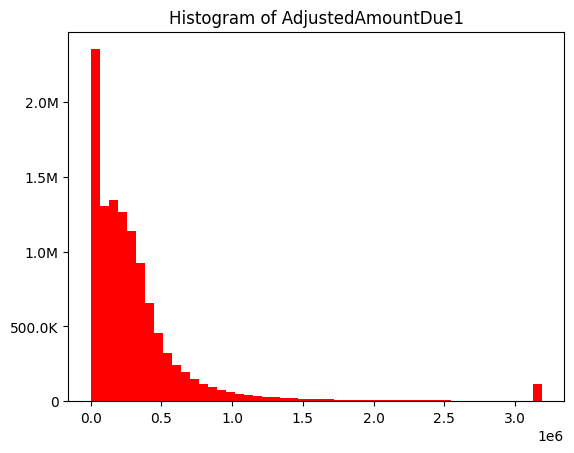

In [ ]:
fig, ax = plt.subplots()
hist(ax, data1.select('AdjustedAmountDue1'), bins = 50, color=['red'])
plt.title("Histogram of AdjustedAmountDue1")
plt.show()

## Model Building

In [ ]:
feature_cols = data4.columns
feature_cols.remove("LatePmt2")

In [ ]:
from pyspark.ml.feature import VectorAssembler

# Convert all features into a vector with name 'features'
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data4 = assembler.transform(data4)

In [ ]:
# Test train split
train, test = data4.randomSplit([0.8,0.2], seed=100)

In [ ]:
train = train.persist()
train.count()

7460923

In [ ]:
#from pyspark.ml.classification import LogisticRegression
#logit = LogisticRegression(labelCol="LatePmt2")
#logit = logit.fit(train)

In [ ]:
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'LatePmt2')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)

In [ ]:
actual = test.select(test.LatePmt2).toPandas()['LatePmt2']

In [ ]:
predictions.where(col("prediction")==1).show(5)

+------+--------------------+--------------------+-------+---------------+------------+------------------+--------+------------------+-------------+--------------+----------+-----------------+-------+------------------+--------------------------+-----------------+------------+--------------+------------+---------------------------+-----------------------------+--------------------------+--------------------------------+---------------------+------------------------+------------------------------+--------+--------+--------+--------------------------+------------------+------------------------+-------------+-----------------+----------------------+--------------------+-----------+-----------+--------------------+--------------------+--------------------+----------+
|Volume|TaxpayerMailingState|TaxpayerPropertyCity|TaxCode|HomeownerExempt|SeniorExempt|SeniorFreezeExempt|BillType|AdjustedAmountDue1|TaxAmountDue1|CostAmountDue1|CofENumber|PastTaxSaleStatus|TaxRate|CondemnationStatus|Municip

In [ ]:
predictions2.where(col("prediction")==0).show(5, truncate=False)

+------+--------------------+--------------------+-------+---------------+------------+------------------+--------+------------------+-------------+--------------+----------+-----------------+-------+------------------+--------------------------+-----------------+------------+--------------+------------+---------------------------+-----------------------------+--------------------------+--------------------------------+---------------------+------------------------+------------------------------+--------+--------+--------+--------------------------+------------------+------------------------+-------------+-----------------+----------------------+--------------------+-----------+-----------+-------------------------------------------------------------------------------------------------------------------------+---------------------------------------+----------------------------------------+----------+---------------+
|Volume|TaxpayerMailingState|TaxpayerPropertyCity|TaxCode|HomeownerExe

In [ ]:
element=f.udf(lambda v:float(v[1]),FloatType())
nums = [0.2, 0.25, 0.3, 0.35, 0.4, 0.5]
acc = []
f1 = []
rec = []
prec = []
for num in nums:
  print(num)
  predictions2 = predictions.withColumn("prob_prediction", when(element("probability")>num, 1).otherwise(0))
  pred = predictions2.select(predictions2.prob_prediction).toPandas()["prob_prediction"]
  pred = pred.tolist()
  acc.append(accuracy_score(actual, pred))
  f1.append(f1_score(actual, pred))
  rec.append(recall_score(actual, pred))
  prec.append(precision_score(actual, pred))


0.2
0.25
0.3
0.35
0.4
0.5


In [ ]:
res_df = pd.DataFrame(nums, columns=["Threshold"])
res_df["Acc"] = acc
res_df["F1"] = f1
res_df["Rec"] = rec
res_df["Prec"] = prec
res_df

,Threshold,Acc,F1,Rec,Prec
0,0.20,0.898545,0.508064,0.507650,0.508479
1,0.25,0.903438,0.509589,0.486125,0.535434
2,0.30,0.914462,0.508735,0.429158,0.624542
3,0.35,0.917957,0.476846,0.362302,0.697302
4,0.40,0.918561,0.455075,0.329505,0.735278
5,0.50,0.918379,0.407131,0.271556,0.813042


In [ ]:
cm = confusion_matrix(actual, pred)
tn, fp, fn, tp = cm.ravel()

In [ ]:
print("Accuracy: ", accuracy_score(actual, pred))
print("F1 Score: ", f1_score(actual, pred))
print("Precision: ", precision_score(actual, pred))
print("Recall: ", recall_score(actual, pred))

In [ ]:
print("True Negatives: ", tn)
print("False Positives: ", fp)
print("False Negatives: ", fn)
print("True Positives: ", tp)

True Negatives:  1661930
False Positives:  10219
False Negatives:  147196
True Positives:  45232


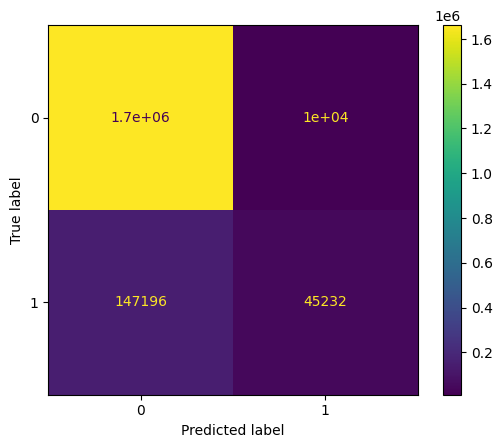

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
feat_imp = rfModel.featureImportances

In [ ]:
feat_imp = [c for c in feat_imp]

In [ ]:
feat_imp

In [ ]:
train_cols = train.columns
train_cols.remove("features")
train_cols.remove("LatePmt2")
feat_df = pd.DataFrame(train_cols, columns=["Features"])
feat_df["Importance"] = feat_imp
feat_df.sort_values("Importance", ascending=False)

,Features,Importance
28,DiffPmt1,3.715082e-01
27,LatePmt1,1.963587e-01
37,LatePmt1Sum,1.818436e-01
34,WOE_LastPaymentSource1,1.162163e-01
36,LatePmt2Sum,5.716733e-02
35,PastTaxSaleStatusSum,2.044941e-02
12,PastTaxSaleStatus,1.226229e-02
9,TaxAmountDue1,1.030470e-02
13,TaxRate,9.716395e-03
10,CostAmountDue1,5.080882e-03
